# Semestrální projekt předměru Počítačový návrh léčiv

In [121]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Crippen
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
from rdkit.Chem import Draw
import seaborn as sns

from sklearn import preprocessing
from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold

Používám dataset [Papyrus](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-022-00672-x), konkrétněji jeho subset Papyrus++, který je složen z velmi kvalitních dat. Jako receptor jsem si vybral [Q194T2](https://www.uniprot.org/uniprotkb/Q194T2/entry), tedy protein z viru chřipky. Jako decoys používám sample ze zbytku datasetu o stejné velikosti jako aktivní set.

In [93]:
data = pd.read_csv('../../05.6++_combined_set_without_stereochemistry.tsv', sep='\t',
                   usecols=["Activity_ID", "SMILES", "target_id", "pchembl_value_Mean"])
data.rename(columns={"pchembl_value_Mean": "Activity"}, inplace=True)
actives = data[data["target_id"] == "Q194T2_WT"].drop(columns=["target_id"])
actives.reset_index(drop=True, inplace=True)
actives["active"] = "Active"

decoys = data[(data["target_id"] != "Q194T2_WT") & (~data["SMILES"].isin(actives["SMILES"].to_list()))]
decoys = decoys.drop_duplicates(subset=["SMILES"]).sample(actives.shape[0], random_state=42).drop(columns=["target_id"])
decoys.reset_index(drop=True, inplace=True)
decoys["Activity"] = 0
decoys["active"] = "Decoy"
data = pd.concat([actives, decoys]).reset_index(drop=True)

In [94]:
data["mol"] = data.apply(lambda row: Chem.MolFromSmiles(row["SMILES"]), axis=1)

In [95]:
def scaffold(mol):
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol)
    except ValueError:
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff)
    smiles = Chem.MolToSmiles(scaff)
    return smiles

data["scaffold"] = data.apply(lambda row: scaffold(row["mol"]), axis=1)

[18:11:45] Explicit valence for atom # 18 C, 6, is greater than permitted
[18:11:47] Explicit valence for atom # 27 C, 6, is greater than permitted
[18:11:48] Explicit valence for atom # 12 C, 6, is greater than permitted


In [96]:
actives_top10 = data[data["Activity"] != 0].groupby("scaffold")["Activity_ID"].count().sort_values(ascending=False).head(10).reset_index()
decoys_top10 = data[data["Activity"] == 0].groupby("scaffold")["Activity_ID"].count().sort_values(ascending=False).head(10).reset_index()

Relativní zastoupení 10 nejčastějších scaffoldů v aktivním setu

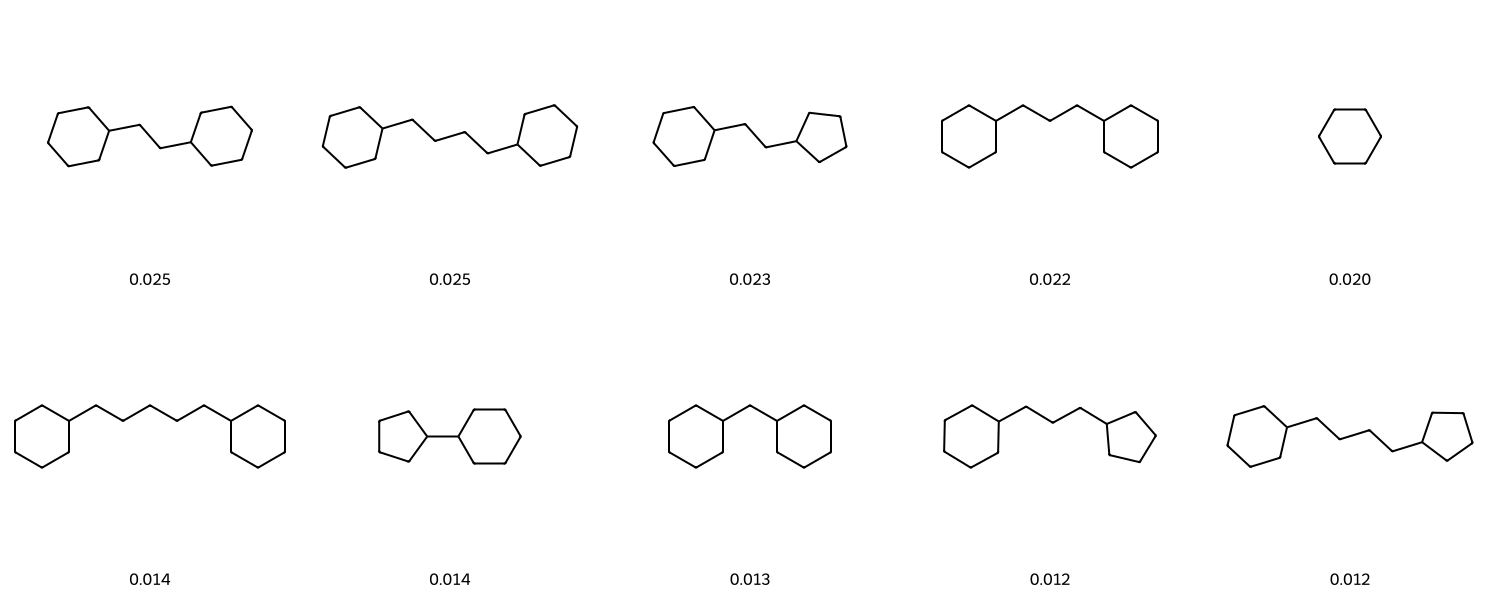

In [97]:
legend = [f"{mol / (len(data) / 2):.3f}" for mol in actives_top10["Activity_ID"].to_list()]
Draw.MolsToGridImage([Chem.MolFromSmiles(scaff) for scaff in actives_top10["scaffold"]], molsPerRow=5, subImgSize=(300, 300), legends=legend)

Relativní zastoupení 10 nejčastějších scaffoldů v neaktivním setu

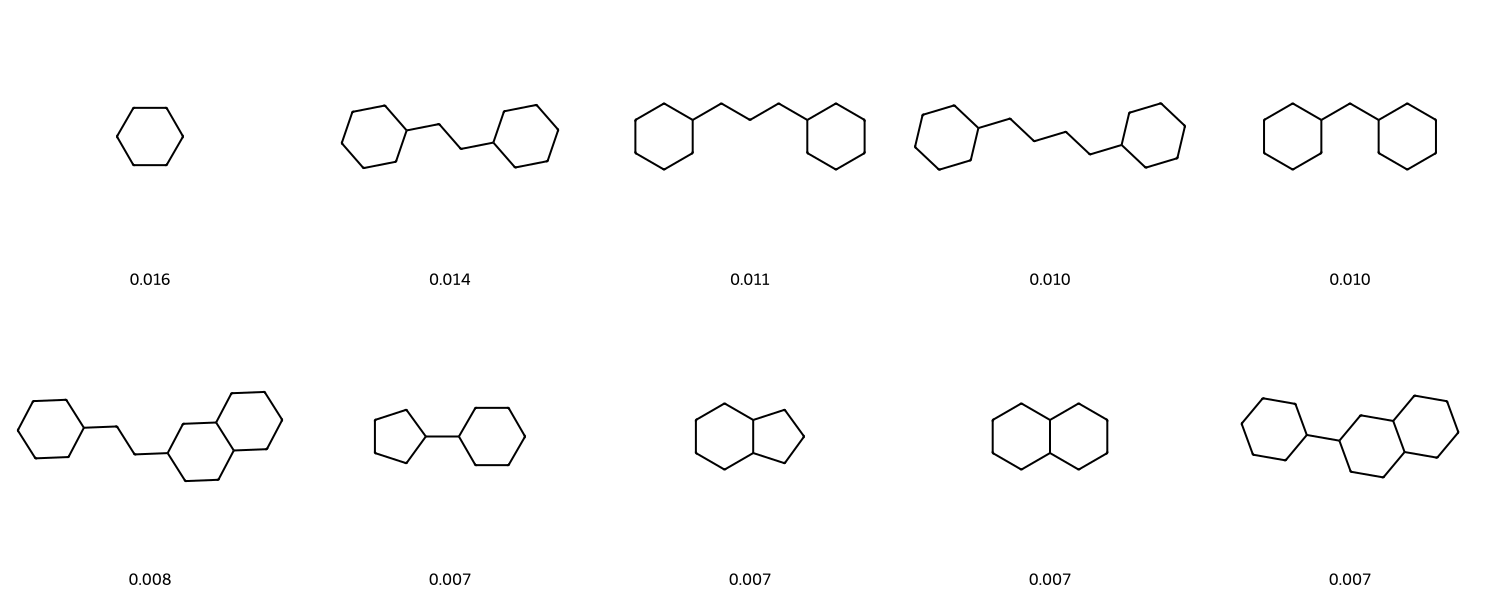

In [99]:
legend = [f"{mol/(len(data)/2):.3f}" for mol in decoys_top10["Activity_ID"].to_list()]
Draw.MolsToGridImage([Chem.MolFromSmiles(scaff) for scaff in decoys_top10["scaffold"]], molsPerRow=5, subImgSize=(300, 300), legends=legend)

In [100]:
data = data.join(
    pd.DataFrame(
        list(
            data.apply(lambda row: (
                rdMolDescriptors.CalcNumHBA(row["mol"]),
                rdMolDescriptors.CalcNumHBD(row["mol"]),
                Crippen.MolLogP(row["mol"]),
                rdMolDescriptors.CalcNumRotatableBonds(row["mol"])
            ), axis=1)
        ), columns=["NumHBA", "NumHBD", "CLogP", "RotBonds"]))

Text(0.5, 1.0, 'Comparison between active and decoy')

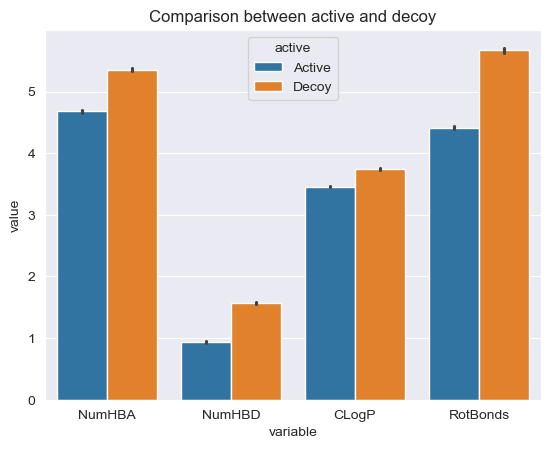

In [101]:
melted_df = pd.melt(data, id_vars=['active'], value_vars=["NumHBA", "NumHBD", "CLogP", "RotBonds"])
sns.barplot(x='variable', y='value', hue='active', data=melted_df, dodge=True).set_title("Comparison between active and decoy")

In [102]:
data = data.join(
    pd.DataFrame(
        (rdMolDescriptors.MQNs_(mol) for mol in data["mol"]), 
        columns=[f"MQN{i}" for i in range(1,43)]))
norm = preprocessing.normalize(data[[f"MQN{i}" for i in range(1,43)]])

In [103]:
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(norm), columns=["PC1", "PC2"])
pca_data["Source"] = data["active"]

[Text(0.5, 1.0, 'Clustering visualization on PCA plot')]

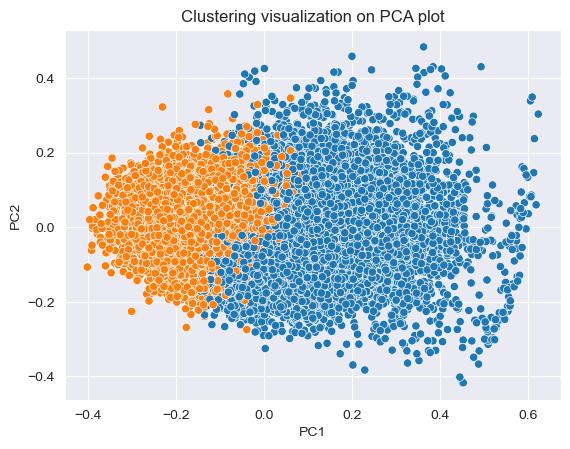

In [104]:
c = cluster.AgglomerativeClustering(linkage="ward", n_clusters=2)
c.fit(norm)
pca_data["labels"] = c.labels_
sns.scatterplot(pca_data, x="PC1", y="PC2", hue="labels", palette=sns.color_palette(n_colors=2), legend=False).set(title="Clustering visualization on PCA plot")

Text(0.5, 1.0, 't-SNE visualization')

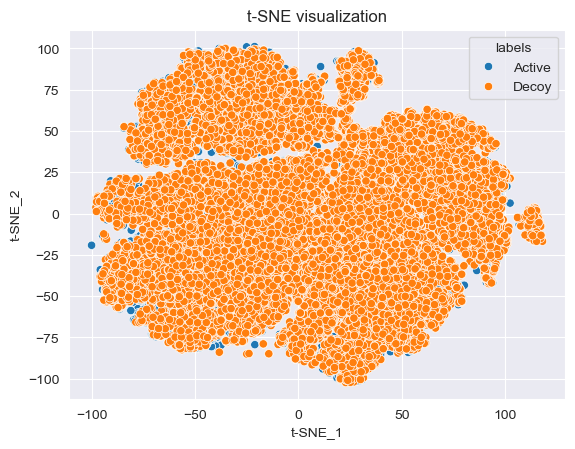

In [105]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_data = tsne.fit_transform(data[[f"MQN{i}" for i in range(1,43)]])
tsne_data = pd.DataFrame(tsne_data, columns=["t-SNE_1", "t-SNE_2"])
tsne_data["labels"] = data["active"]
sns.scatterplot(tsne_data, x="t-SNE_1", y="t-SNE_2", hue="labels", palette=sns.color_palette(n_colors=2)).set_title("t-SNE visualization")

In [106]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
data_vect = pd.DataFrame(
        [mfpgen.GetFingerprint(mol).ToList() for mol in data["mol"]], 
        columns=[f"{i}" for i in range(0,2048)])

C:\Users\vilif\miniconda3\envs\cdd\Lib\site-packages\umap\umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


Text(0.5, 1.0, 'UMAP visualization')

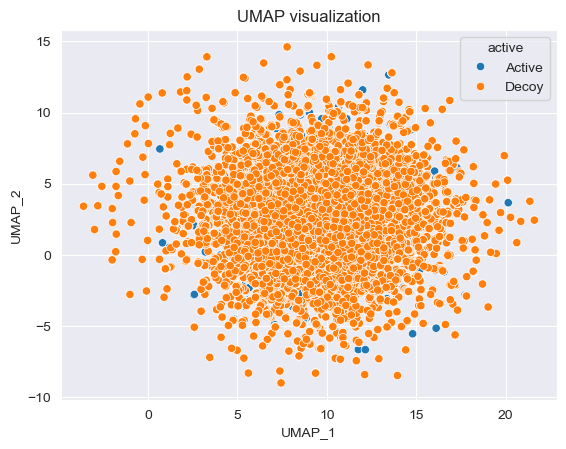

In [107]:
um = UMAP(metric="jaccard", n_neighbors=5, n_jobs=-1)
norm = preprocessing.normalize(data_vect)
um_data = um.fit_transform(norm)
um_data = pd.DataFrame(um_data, columns=["UMAP_1", "UMAP_2"])
um_data["active"] = data["active"]
sns.scatterplot(um_data, x="UMAP_1", y="UMAP_2", hue="active", palette=sns.color_palette(n_colors=2)).set_title("UMAP visualization")

## Klasifikace
Random Forest Classifier

In [132]:
X_train, X_test, y_train, y_test = train_test_split(data[[f"MQN{i}" for i in range(1,43)]], data["active"], random_state=42)

In [122]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
clf = RandomForestClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

clf = RandomForestClassifier(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred)
y_pred = clf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print("Accuracy Train:", acc_train, ", Accuracy Test:", acc_test)

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy Train: 0.9785213075474928 , Accuracy Test: 0.758428889269211


K Neighbours Classifier

In [133]:
param_grid = {
    'n_neighbors': [2, 5, 10, 20],
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
clf = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

clf = KNeighborsClassifier(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred)
y_pred = clf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print("Accuracy Train:", acc_train, ", Accuracy Test:", acc_test)

Best Parameters: {'n_neighbors': 20}
Accuracy Train: 0.7355239888185293 , Accuracy Test: 0.7111073078897826


## Regrese
Random Forest Regressor na aktivním setu

In [130]:
actives = data[data["Activity"] > 0]
X_train, X_test, y_train, y_test = train_test_split(actives[[f"MQN{i}" for i in range(1,43)]], actives["Activity"], random_state=42)

In [131]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
clf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

clf = RandomForestRegressor(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred)
y_pred = clf.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error Train:", rmse_train, "Test:", rmse_test)

Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Root Mean Squared Error Train: 0.34547089307556517 Test: 0.37462525757144627
